In [ ]:
import os
import gc
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
import innvestigate
# This is required for innvestigate and must be called before models are loaded.
tf.compat.v1.disable_eager_execution()
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras import regularizers
from keras.models import Model
from keras.layers import Dense,LeakyReLU, Dropout, Add, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import Callback
from matplotlib.colors import Normalize
from sklearn.preprocessing import FunctionTransformer
tf.keras.utils.set_random_seed(0)
tf.config.list_physical_devices('GPU')
tf.compat.v1.disable_eager_execution()
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.engine.training_v1")
import xarray as xr
#import innvestigate
import scipy.io as sio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.signal import butter, sosfilt
from tensorflow.keras.models import load_model

2025-10-19 03:24:28.751209: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-19 03:24:28.858892: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-19 03:24:28.892898: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
In_name = "TS_anom" #
Out_name = "TOA_anom" #


#====================== Here is 1D data ===============================#

file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-historical.ens-mean.ANN.1850-2014.nc"
# file_2xCO2 = "/ocean/projects/ees240007p/hwei1/Yue/test/test.2xCO2.ANN.new.nc"
file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/MPI-ESM1-2-HR/ML-data/test.MPI-ESM1-2-HR.4xCO2.ANN.nc"


# === Load historical data ===
ds_hist = xr.open_dataset(file_hist)
print("Historical dataset loaded:", ds_hist)


Historical dataset loaded: <xarray.Dataset>
Dimensions:   (time: 165, lon: 288, lat: 192)
Coordinates:
  * time      (time) object 1850-06-16 00:00:00 ... 2014-06-16 00:00:00
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Data variables:
    TS        (time, lat, lon) float32 ...
    TS_anom   (time, lat, lon) float64 ...
    TOA       (time) float64 ...
    TOA_anom  (time) float64 ...
Attributes:
    ERF:      ERF = F - F_ctrl (from Isla's ERFMIP runs)
    script:   /glade/work/dongy24/Python/create_input_for_huaiyu_CESM2.ipynb
    author:   Y. Dong, 04/02/2025


In [4]:
lat = ds_hist["lat"]
lon = ds_hist["lon"]

time_hist = ds_hist["time"] 
time_hist = [date.year for date in time_hist.values] #for C2 data

TS_hist = ds_hist[In_name]
TOA_hist = ds_hist[Out_name].values

# === Load 2xCO2 data ===
# ds_2xCO2 = xr.open_dataset(file_2xCO2)
# print("2xCO2 dataset loaded:", ds_2xCO2)

# time_2xCO2 = ds_2xCO2["year"]
# TS_2xCO2 = ds_2xCO2[In_name]
# TOA_2xCO2 = ds_2xCO2[Out_name].values

# === Load 4xCO2 data ===
ds_4xCO2 = xr.open_dataset(file_4xCO2)
print("4xCO2 dataset loaded:", ds_4xCO2)


# # time_4xCO2_coords = ds_4xCO2["year"]
# # time_4xCO2 = time_4xCO2_coords.values

time_4xCO2 = ds_4xCO2["time"] 
#time_4xCO2 = np.array([date.year for date in time_4xCO2.values])

TS_4xCO2 = ds_4xCO2[In_name]
TOA_4xCO2 = ds_4xCO2[Out_name].values

# print("TS_2xCO2 shape:", TS_2xCO2.shape)
print("TS_4xCO2 shape:", TS_4xCO2.shape)

4xCO2 dataset loaded: <xarray.Dataset>
Dimensions:   (time: 150, lon: 384, lat: 192)
Coordinates:
  * time      (time) datetime64[ns] 1850-07-01T06:00:00 ... 1999-07-01T06:00:00
  * lon       (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
  * lat       (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
Data variables:
    TS        (time, lat, lon) float32 ...
    TS_anom   (time, lat, lon) float32 ...
    TOA       (time) float32 ...
    TOA_anom  (time) float32 ...
Attributes:
    script:   verify_cmip6.py
    author:   Modified for ML testing
TS_4xCO2 shape: (150, 192, 384)


In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy import ndimage # New import for spatial smoothing
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def calculate_trend_and_significance_temporal_smooth(relevance_data, time_axis, p_value_threshold=0.05, window_size=5):
    """
    Applies temporal smoothing (running mean) to relevance time series before
    calculating the linear trend and significance.
    'window_size' is the number of years for the running mean.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    if time_axis.ndim != 1 or time_axis.shape[0] != relevance_data.shape[0]:
        raise ValueError("Time axis must be 1D and match the time dimension of data.")

    num_time, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)
    significance_mask = np.full((lat_dim, lon_dim), False, dtype=bool)

    print(f"    Calculating trends with temporal smoothing (window={window_size}) for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            
            if np.all(np.isfinite(relevance_timeseries)):
                # Apply temporal smoothing using a rolling mean
                # Using pandas for convenient rolling mean with handling of edges
                series = pd.Series(relevance_timeseries)
                smoothed_timeseries = series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
                
                # Filter out NaNs that might be introduced by rolling mean if window is large
                valid_indices = ~np.isnan(smoothed_timeseries)
                
                if np.sum(valid_indices) > 1: # Need at least 2 points for regression
                    current_time_axis = time_axis[valid_indices]
                    current_data = smoothed_timeseries[valid_indices]
                    
                    if len(current_data) > 1: # Still need at least 2 points after NaN removal
                        lin_reg_result = stats.linregress(x=current_time_axis, y=current_data)
                        trend_map[y, x] = lin_reg_result.slope
                        if lin_reg_result.pvalue < p_value_threshold:
                            significance_mask[y, x] = True
    print("    Trend and significance calculation with temporal smoothing complete.")
    return trend_map, significance_mask

def calculate_trend_and_significance(relevance_data, time_axis, p_value_threshold=0.1):
    """
    Calculates the linear trend (slope) and a significance mask
    at each grid cell over time.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    if time_axis.ndim != 1 or time_axis.shape[0] != relevance_data.shape[0]:
        raise ValueError("Time axis must be 1D and match the time dimension of data.")

    _, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)
    significance_mask = np.full((lat_dim, lon_dim), False, dtype=bool) # Mask for significance

    print(f"    Calculating trends and significance for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            if np.all(np.isfinite(relevance_timeseries)) and len(relevance_timeseries) > 1:
                lin_reg_result = stats.linregress(x=time_axis, y=relevance_timeseries)
                trend_map[y, x] = lin_reg_result.slope
                if lin_reg_result.pvalue < p_value_threshold:
                    significance_mask[y, x] = True
    print("    Trend and significance calculation complete.")
    return trend_map, significance_mask

def apply_spatial_smoothing(data2d, sigma=1):
    """
    Applies a Gaussian filter to smooth a 2D map.
    Sigma is the standard deviation for Gaussian kernel.
    """
    print(f"    Applying spatial smoothing with sigma={sigma}...")
    smoothed_map = ndimage.gaussian_filter(data2d, sigma=sigma)
    print("    Smoothing complete.")
    return smoothed_map

In [7]:
ds_hist[In_name][0,:,:]

<xarray.DataArray 'TS_anom' (lat: 192, lon: 288)>
[55296 values with dtype=float64]
Coordinates:
    time     object 1850-06-16 00:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes:
    units:    K
    note:     TS_anom = TS_his - TS_ref
    ref:      B1850 yr1001-2000 mean

In [8]:
### load the mean and STD calculated in the Pre-industrial control run for normalization

# Paths to the datasets and trained model

#Try without regrid first 

path_PIc = "/ocean/projects/ees250004p/ezhu3/MPI-ESM1-2-HR/trained_model/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom" #original model


normalization= sio.loadmat(os.path.join(path_PIc, 'Normalization.mat'))

target_lat = ds_hist["lat"]
target_lon = ds_hist['lon']

print("Original 4xCO2 shape:", TS_4xCO2.shape)

# This changes the spatial dimensions from (143, 144) to (192, 288)
#TS_4xCO2_regridded = TS_4xCO2.interp(lat=target_lat, lon=target_lon, method="linear")
#print("New regridded 4xCO2 shape:", TS_4xCO2_regridded.shape)

X_mean = normalization['X_mean']
X_std = normalization['X_std']
y_mean = normalization['y_mean']
y_std = normalization['y_std']


#TS_hist_norm = (TS_hist-X_mean)/X_std.squeeze()
# TS_2xCO2_norm = (TS_2xCO2-X_mean)/X_std.squeeze()

TS_4xCO2_norm = (TS_4xCO2-X_mean)/X_std.squeeze()
TS_4xCO2_norm = TS_4xCO2_norm.values[..., tf.newaxis]

print(X_mean)
print("-"*10)
print(X_std)

Original 4xCO2 shape: (150, 192, 384)
[[0]]
----------
[[[0.72430617]
  [0.72589976]
  [0.7263547 ]
  ...
  [0.72209185]
  [0.7223367 ]
  [0.724851  ]]

 [[1.0830129 ]
  [1.0843921 ]
  [1.083377  ]
  ...
  [1.0827383 ]
  [1.0820953 ]
  [1.0819604 ]]

 [[1.1683515 ]
  [1.17322   ]
  [1.1768548 ]
  ...
  [1.1578457 ]
  [1.1629276 ]
  [1.1644888 ]]

 ...

 [[0.8943648 ]
  [0.89501935]
  [0.8951825 ]
  ...
  [0.8951395 ]
  [0.8950248 ]
  [0.89574474]]

 [[0.8567698 ]
  [0.85688704]
  [0.85653263]
  ...
  [0.85647535]
  [0.8562996 ]
  [0.8564022 ]]

 [[0.80345577]
  [0.80308765]
  [0.80320203]
  ...
  [0.8048911 ]
  [0.80396867]
  [0.80365634]]]


In [9]:
from tensorflow.keras import backend as K
# load the neural network trained from Pre-industrial control simulation

n_folds = 5
n_ensembles = 1

#pred_hist_ALL = np.empty((TOA_hist.shape[0],0))
# pred_2xCO2_ALL = np.empty((TOA_2xCO2.shape[0],0))
pred_4xCO2_ALL = np.empty((TOA_4xCO2.shape[0],0))


for fold_no in range(1,n_folds+1):

    #pred_hist = np.zeros((TOA_hist.shape[0],1));
    # pred_2xCO2 = np.zeros((TOA_2xCO2.shape[0],1));
    pred_4xCO2 = np.zeros((TOA_4xCO2.shape[0],1));
    for ens_no in range(1,n_ensembles+1):
        K.clear_session() # Clears the Keras session and TensorFlow graph
        gc.collect()  
        Model = load_model(os.path.join(path_PIc,'model_fold'+str(fold_no)+'_ens'+str(ens_no)+'.h5'))
        #pred_hist = pred_hist+ Model.predict(TS_hist_norm, batch_size=1)
        # pred_2xCO2 = pred_2xCO2+ Model.predict(TS_2xCO2_norm)
        pred_4xCO2 = pred_4xCO2+ Model.predict(TS_4xCO2_norm)
        
    #pred_hist = pred_hist/n_ensembles
    # pred_2xCO2 = pred_2xCO2/n_ensembles
    pred_4xCO2 = pred_4xCO2/n_ensembles


# re-scale the prediction from the neural network
    #pred_hist = pred_hist*y_std + y_mean
    # pred_2xCO2 = pred_2xCO2*y_std + y_mean
    pred_4xCO2 = pred_4xCO2*y_std + y_mean



    #pred_hist_ALL = np.concatenate(( pred_hist_ALL,pred_hist),axis = 1)
    # pred_2xCO2_ALL = np.concatenate(( pred_2xCO2_ALL,pred_2xCO2),axis = 1)
    pred_4xCO2_ALL = np.concatenate(( pred_4xCO2_ALL,pred_4xCO2),axis = 1)




2025-10-19 03:24:35.883797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-19 03:24:37.286816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0
2025-10-19 03:24:37.355354: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2025-10-19 03:24:40.245357: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2025-10-19 03:24:41.848920: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No suc

In [10]:
def plot_predictions(time, truth, preds, title):
    """
    Plots the ground truth, mean prediction, and individual model predictions with transparency.

    Parameters:
        time (array-like): Time axis values.
        truth (array-like): Ground truth values.
        preds (2D array): Predictions from ensemble or multiple models (shape: time x ensemble).
        title (str): Title of the plot.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot truth
    ax.plot(time, truth, label="Truth", color="C0", linewidth=2)

    # Plot mean prediction
    mean_pred = np.mean(preds, axis=1)
    ax.plot(time, mean_pred, label="Prediction (Mean)", color="C1", linewidth=1.8)

    # Plot individual models
    for i in range(preds.shape[1]):
        ax.plot(time, preds[:, i], linewidth=1, alpha=0.5,
                label="Prediction (CV" + str(i+1) + ")")

    # Style
    ax.set_xlabel("Time (Year)", fontsize=16)
    ax.set_ylabel(Out_name, fontsize=16)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_title(title, fontsize=18, pad=15)
    ax.legend(fontsize=14, loc="best")

    # R² annotation
    r2 = r2_score(truth, mean_pred)
    ax.text(0.02, 0.95, f"$R^2$ = {r2:.3f}", transform=ax.transAxes,
            fontsize=16, bbox=dict(facecolor="white", edgecolor="black", alpha=0.5))

    plt.tight_layout()
    plt.show()


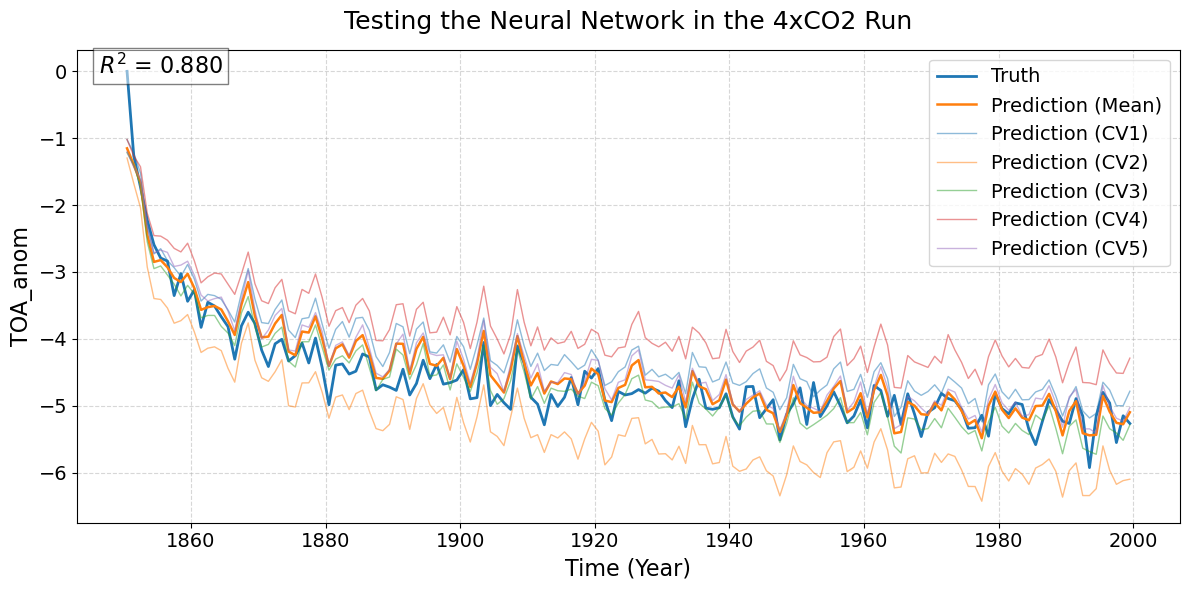

In [11]:
#plot_predictions(time_hist, TOA_hist, pred_hist_ALL,
#                 "Testing the Neural Network in the Historical Run")


#plot_predictions(time_2xCO2, TOA_2xCO2, pred_2xCO2_ALL,
#                  "Testing the Neural Network in the 2xCO2 Run")


plot_predictions(time_4xCO2, TOA_4xCO2, pred_4xCO2_ALL,
                 "Testing the Neural Network in the 4xCO2 Run")



Finished prediction. Final predicted TOA (N_pred) shape: (150,)
Loaded dT (TS anomaly) from: /ocean/projects/ees250004p/ezhu3/data/MPI-ESM1-2-HR/ML-data/MPI-ESM1-2-HR_abrupt-4xCO2-150_ts_gm_anom_GM_timeseries.nc

--- Step 3: Performing Gregory regression ---
CMIP6 Data: Lambda (λ) = 1.297 W m⁻² K⁻¹
NN Prediction: Lambda (λ) = 1.270 W m⁻² K⁻¹

--- Step 4: Generating plot ---


/var/tmp/ipykernel_49989/3369269902.py:71: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  plt.tight_layout()
/var/tmp/ipykernel_49989/3369269902.py:72: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  plt.savefig(f"{MODEL_NAME}_Gregory_Plot_NN_Comparison.png", dpi=300)



Plot saved as MPI-ESM1-2-HR_Gregory_Plot_NN_Comparison.png


/jet/home/ezhu3/.conda/envs/tf210/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


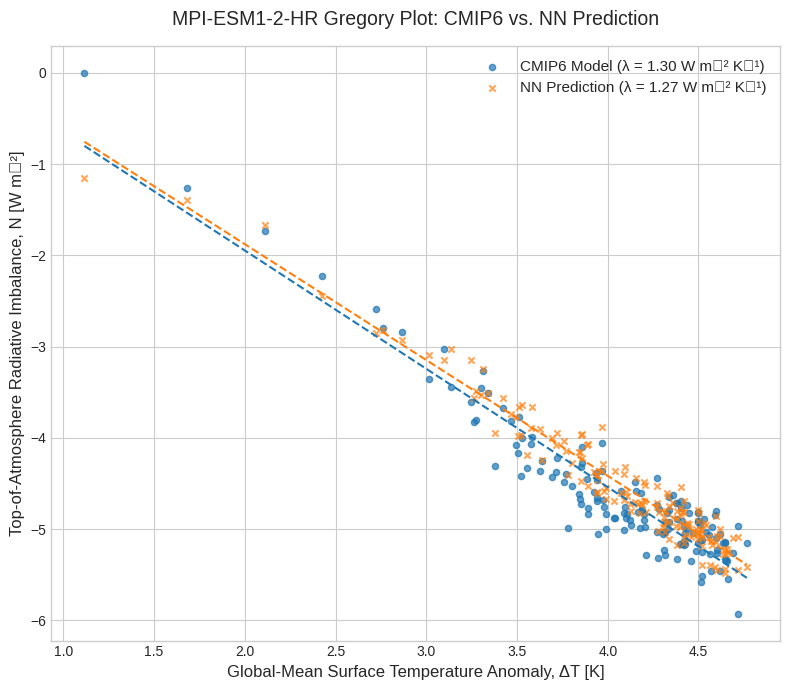

In [12]:
# Average the predictions across all folds for a final result
N_pred = np.nanmean(pred_4xCO2_ALL, axis=1)
print(f"\nFinished prediction. Final predicted TOA (N_pred) shape: {N_pred.shape}")

MODEL_NAME = "MPI-ESM1-2-HR"
EXPERIMENT_NAME = "abrupt-4xCO2-150"


ts_anom_path = "/ocean/projects/ees250004p/ezhu3/data/MPI-ESM1-2-HR/ML-data/MPI-ESM1-2-HR_abrupt-4xCO2-150_ts_gm_anom_GM_timeseries.nc"
ds_ts_anom = xr.open_dataset(ts_anom_path, engine="netcdf4")

toa_anom_path = "/ocean/projects/ees250004p/ezhu3/data/MPI-ESM1-2-HR/ML-data/MPI-ESM1-2-HR_abrupt-4xCO2-150_toa_gm_anom_GM_timeseries.nc"
ds_toa_anom = xr.open_dataset(toa_anom_path, engine="netcdf4")
N_cmip6 = ds_toa_anom['toa_gm_anom'].values


dT = ds_ts_anom['ts_gm_anom'].values
print(f"Loaded dT (TS anomaly) from: {ts_anom_path}")

# ===============================================================
# STEP 3: PERFORM GREGORY REGRESSION (N vs. dT)
# ===============================================================
print("\n--- Step 3: Performing Gregory regression ---")

# Remove any NaNs that could interfere with regression
valid_indices = np.isfinite(dT) & np.isfinite(N_cmip6) & np.isfinite(N_pred)
dT_valid = dT[valid_indices]
N_cmip6_valid = N_cmip6[valid_indices]
N_pred_valid = N_pred[valid_indices]

# Regression for the CMIP6 ground truth data
slope_cmip6, intercept_cmip6 = np.polyfit(dT_valid, N_cmip6_valid, 1)
lambda_cmip6 = -slope_cmip6
print(f"CMIP6 Data: Lambda (λ) = {lambda_cmip6:.3f} W m⁻² K⁻¹")

# Regression for the predicted data from the neural network
slope_pred, intercept_pred = np.polyfit(dT_valid, N_pred_valid, 1)
lambda_pred = -slope_pred
print(f"NN Prediction: Lambda (λ) = {lambda_pred:.3f} W m⁻² K⁻¹")


# ===============================================================
# STEP 4: PLOT THE RESULTS FOR COMPARISON
# ===============================================================
print("\n--- Step 4: Generating plot ---")

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 7))

# Plot scatter points for CMIP6 data and NN predictions
ax.scatter(dT_valid, N_cmip6_valid, s=20, alpha=0.7,
           label=f"CMIP6 Model (λ = {lambda_cmip6:.2f} W m⁻² K⁻¹)")
ax.scatter(dT_valid, N_pred_valid, s=20, alpha=0.7, marker='x',
           label=f"NN Prediction (λ = {lambda_pred:.2f} W m⁻² K⁻¹)")

# Plot regression lines
x_reg = np.array([dT_valid.min(), dT_valid.max()])
y_reg_cmip6 = slope_cmip6 * x_reg + intercept_cmip6
y_reg_pred = slope_pred * x_reg + intercept_pred

ax.plot(x_reg, y_reg_cmip6, color='tab:blue', linestyle='--')
ax.plot(x_reg, y_reg_pred, color='tab:orange', linestyle='--')

# Formatting the plot
ax.set_xlabel("Global-Mean Surface Temperature Anomaly, ΔT [K]", fontsize=12)
ax.set_ylabel("Top-of-Atmosphere Radiative Imbalance, N [W m⁻²]", fontsize=12)
ax.set_title(f"{MODEL_NAME} Gregory Plot: CMIP6 vs. NN Prediction", fontsize=14, pad=15)
ax.legend(fontsize=11)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.savefig(f"{MODEL_NAME}_Gregory_Plot_NN_Comparison.png", dpi=300)
print(f"\nPlot saved as {MODEL_NAME}_Gregory_Plot_NN_Comparison.png")
plt.show()

In [13]:
ds_PI = xr.open_dataset("/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc")

# Check the metadata
print(ds_PI["TOA_anom"].attrs)

{'units': 'W/m2', 'note': 'R_anom = TOA - TOA_ref - ERF(9.07)', 'ref': 'B1850 yr1001-2000 mean'}



▶️ PROCESSING LRP FOR SCENARIO: 4XCO2
    Analyzing model: model_fold1_ens1.h5


2025-10-19 03:24:48.446809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5


2025-10-19 03:24:50.491576: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5


2025-10-19 03:24:51.945039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5


2025-10-19 03:24:53.388618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5


2025-10-19 03:24:54.857726: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


✅ Full attribution map saved to: attribution_map_4xCO2.npy


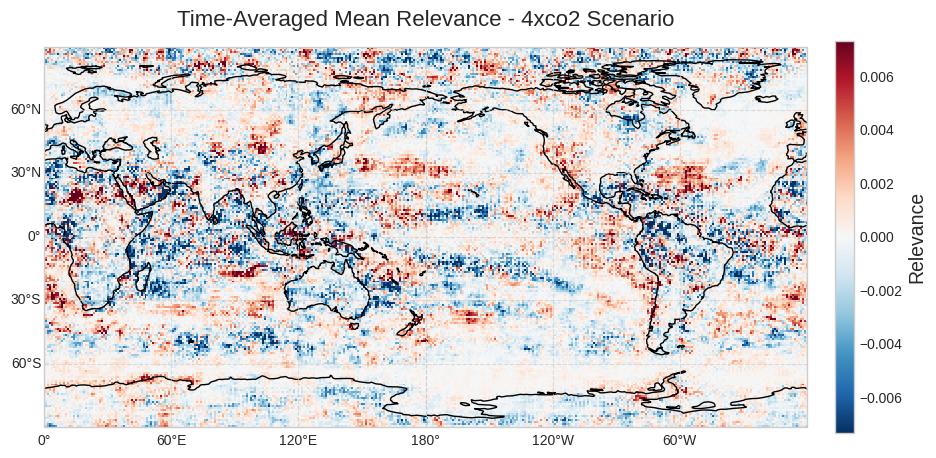

\n======================================================\n▶️ COMPARING GLOBAL SUMS FOR SCENARIO: 4XCO2\n======================================================
    Analyzing model: model_fold1_ens1.h5 with epsilon = 10


2025-10-19 03:24:57.808627: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5 with epsilon = 10


2025-10-19 03:24:59.308220: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5 with epsilon = 10


2025-10-19 03:25:00.766699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5 with epsilon = 10


2025-10-19 03:25:02.210155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5 with epsilon = 10


2025-10-19 03:25:03.671438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Global sum of map (ε = 10): -0.7246


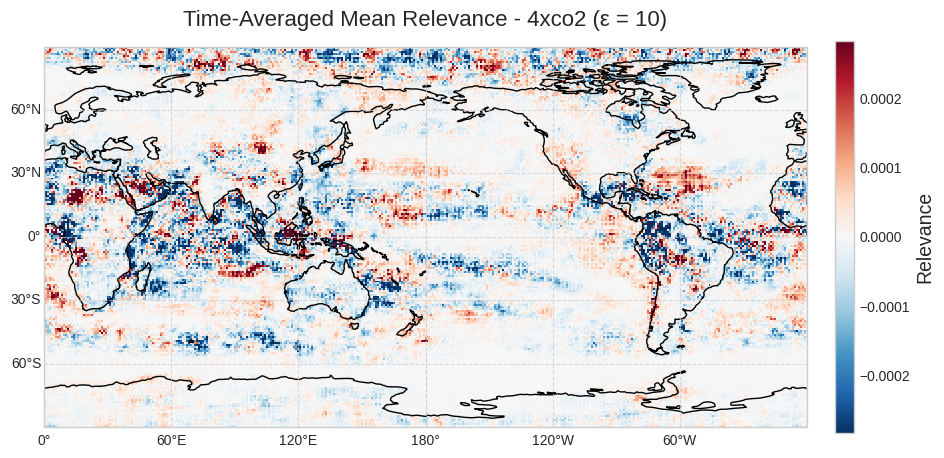

    Analyzing model: model_fold1_ens1.h5 with epsilon = 20


2025-10-19 03:25:06.087191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5 with epsilon = 20


2025-10-19 03:25:07.521731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5 with epsilon = 20


2025-10-19 03:25:08.991116: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5 with epsilon = 20


2025-10-19 03:25:10.455241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5 with epsilon = 20


2025-10-19 03:25:11.939763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Global sum of map (ε = 20): -0.1672


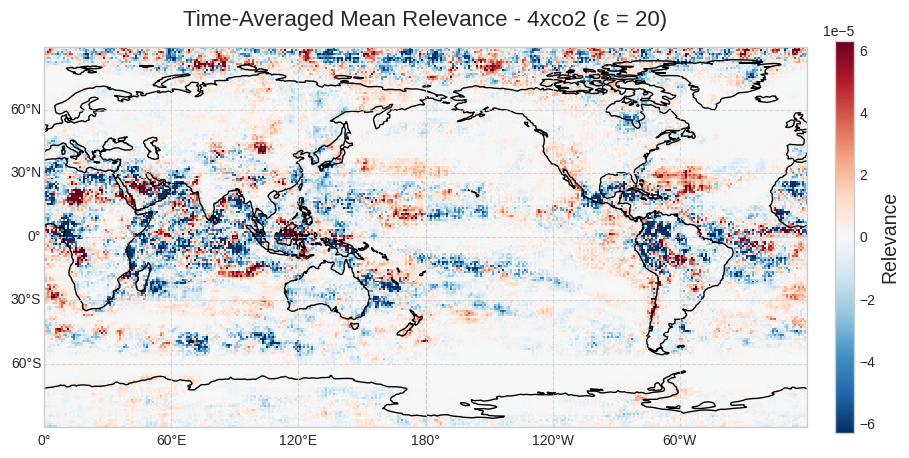

    Analyzing model: model_fold1_ens1.h5 with epsilon = 30


2025-10-19 03:25:14.387198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5 with epsilon = 30


2025-10-19 03:25:15.801529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5 with epsilon = 30


2025-10-19 03:25:17.213586: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5 with epsilon = 30


2025-10-19 03:25:18.642859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5 with epsilon = 30


2025-10-19 03:25:20.072825: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Global sum of map (ε = 30): -0.0604


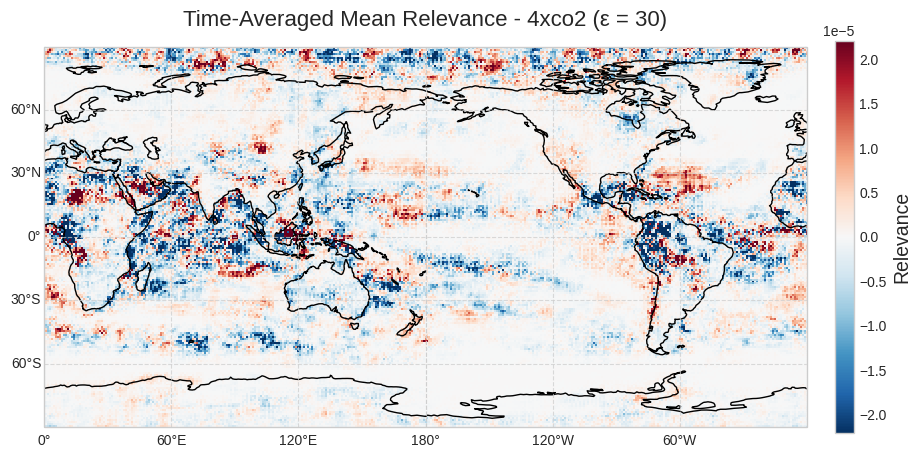

    Analyzing model: model_fold1_ens1.h5 with epsilon = 50


2025-10-19 03:25:22.469271: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5 with epsilon = 50


2025-10-19 03:25:23.900269: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5 with epsilon = 50


2025-10-19 03:25:25.314738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5 with epsilon = 50


2025-10-19 03:25:26.740618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5 with epsilon = 50


2025-10-19 03:25:28.170676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Global sum of map (ε = 50): -0.0142


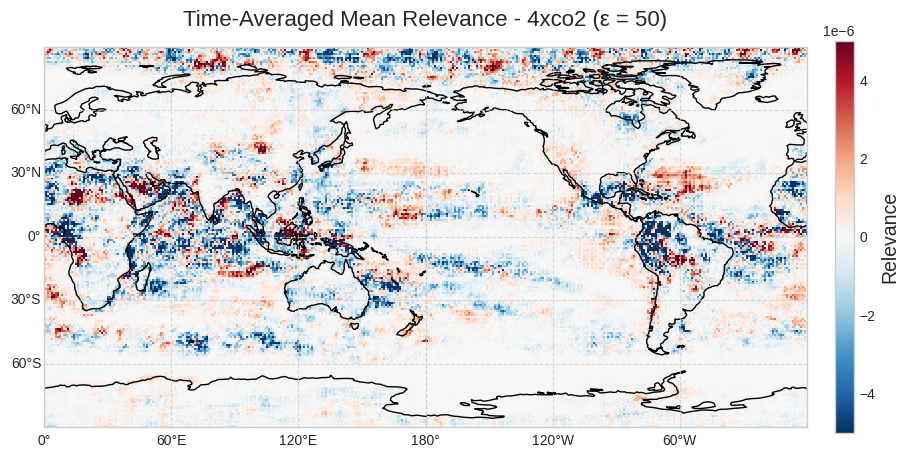

    Analyzing model: model_fold1_ens1.h5 with epsilon = 100


2025-10-19 03:25:30.569322: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5 with epsilon = 100


2025-10-19 03:25:31.984740: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5 with epsilon = 100


2025-10-19 03:25:33.403193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5 with epsilon = 100


2025-10-19 03:25:34.862206: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5 with epsilon = 100


2025-10-19 03:25:36.305645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Global sum of map (ε = 100): -0.0015


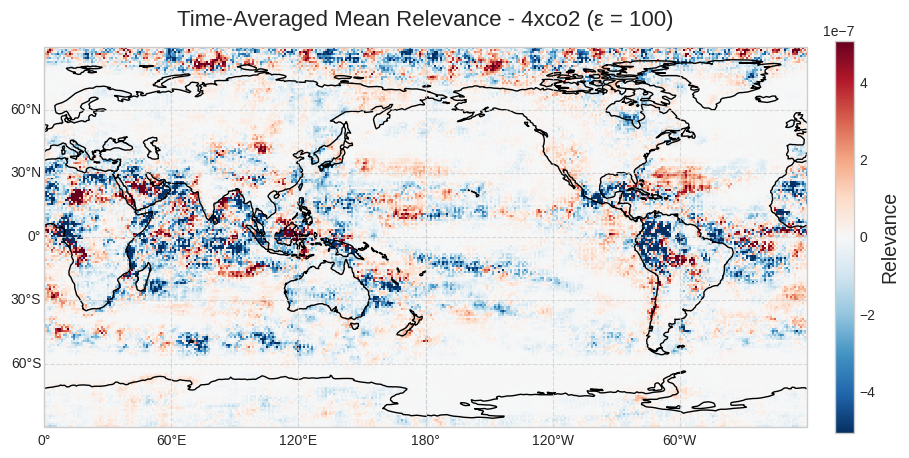

    Analyzing model: model_fold1_ens1.h5 with epsilon = 200


2025-10-19 03:25:38.667270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5 with epsilon = 200


2025-10-19 03:25:40.094828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5 with epsilon = 200


2025-10-19 03:25:41.523665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5 with epsilon = 200


2025-10-19 03:25:43.021475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5 with epsilon = 200


2025-10-19 03:25:44.649154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Global sum of map (ε = 200): -0.0001


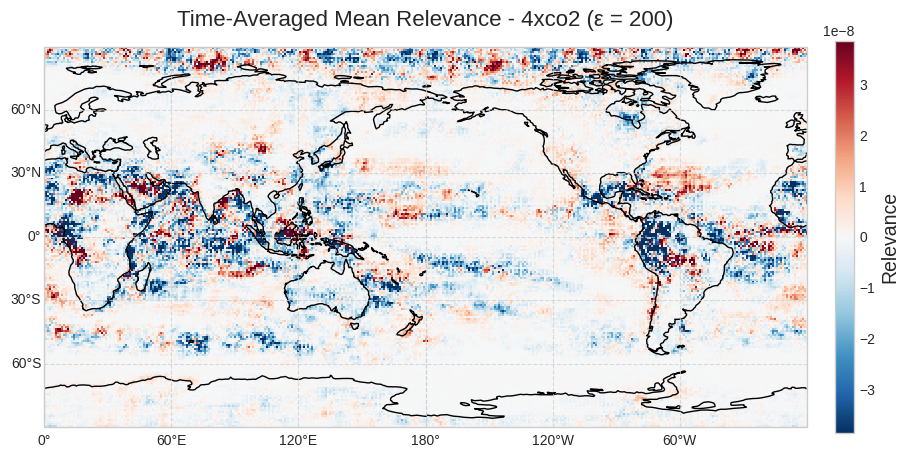

    Analyzing model: model_fold1_ens1.h5 with epsilon = 500


2025-10-19 03:25:47.512226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold2_ens1.h5 with epsilon = 500


2025-10-19 03:25:49.148786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold3_ens1.h5 with epsilon = 500


2025-10-19 03:25:50.867588: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold4_ens1.h5 with epsilon = 500


2025-10-19 03:25:52.537576: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


    Analyzing model: model_fold5_ens1.h5 with epsilon = 500


2025-10-19 03:25:54.219200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 19992 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


In [ ]:
def plot_pacific_centered_map(lon, lat, data2d, title, cbar_label="Relevance"):
    """
    Plots a 2D global map using Cartopy, centered on the Pacific Ocean,
    with a tight, percentile-based color scale.
    """
    # Set color scale limit based on the 98th percentile to see patterns clearly
    vmax = np.nanpercentile(np.abs(data2d), 98)
    vmin = -vmax
    
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    
    pcm = ax.pcolormesh(lon, lat, data2d, cmap="RdBu_r", transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax)
    
    ax.coastlines(zorder=2)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.top_labels = False; gl.right_labels = False
    
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar.set_label(cbar_label, fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    plt.show()

def ensemble_lrp_analyze(model_dir, num_folds, data_to_analyze):
    """
    Loads each model in an ensemble, generates its LRP map, and returns
    the averaged map from all models.
    """
    all_relevance_maps = []
    for i in range(1, num_folds + 1):
        K.clear_session(); gc.collect()
        model_path = os.path.join(model_dir, f'model_fold{i}_ens1.h5')
        print(f"    Analyzing model: {os.path.basename(model_path)}")
        try:
            model = load_model(model_path)
            # The analyzer needs the model without the final activation if it's not linear
            analyzer = innvestigate.create_analyzer("lrp.epsilon", model)
            relevance = analyzer.analyze(data_to_analyze)
            all_relevance_maps.append(relevance)
        except Exception as e:
            print(f"      ❌ ERROR analyzing model {i}: {e}")
            continue
    
    if not all_relevance_maps:
        return None
        
    # Stack along a new axis and compute the mean across the folds
    ensemble_relevance = np.mean(np.stack(all_relevance_maps), axis=0)
    return ensemble_relevance

# --- 4. Main LRP Analysis and Plotting ---
TEST_SCENARIOS = {
    #"historical": TS_hist_norm,
    "4xCO2": TS_4xCO2_norm
}

lon = ds_4xCO2["lon"].values  # Should be (144,)
lat = ds_4xCO2["lat"].values  # Should be (143,)

for scenario, data in TEST_SCENARIOS.items():
    print(f"\n======================================================")
    print(f"▶️ PROCESSING LRP FOR SCENARIO: {scenario.upper()}")
    print(f"======================================================")
    
    # Generate the full [time, lat, lon] attribution map
    attribution_map = ensemble_lrp_analyze(
        model_dir=path_PIc,
        num_folds=n_folds,
        data_to_analyze=data
    )
    
    if attribution_map is not None:
        # Squeeze out the channel dimension for saving and plotting
        attribution_map = attribution_map.squeeze()
        
        # Save the full attribution map for future analyses
        output_filename = f"attribution_map_{scenario}.npy"
        np.save(output_filename, attribution_map)
        print(f"✅ Full attribution map saved to: {output_filename}")
        
        # Calculate the time-averaged mean relevance
        mean_relevance_map = np.mean(attribution_map, axis=0)
        
        # Plot the mean relevance map
        plot_pacific_centered_map(
            lon, lat, mean_relevance_map,
            title=f"Time-Averaged Mean Relevance - {scenario.capitalize()} Scenario"
        )

def ensemble_lrp_analyze_with_epsilon(model_dir, num_folds, data_to_analyze, epsilon_value):
    """
    Loads each model in an ensemble, generates its LRP map with a specific epsilon,
    and returns the averaged map.
    """
    all_relevance_maps = []
    for i in range(1, num_folds + 1):
        K.clear_session(); gc.collect()
        model_path = os.path.join(model_dir, f'model_fold{i}_ens1.h5')
        print(f"    Analyzing model: {os.path.basename(model_path)} with epsilon = {epsilon_value}")
        try:
            model = load_model(model_path)
            analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=epsilon_value)
            relevance = analyzer.analyze(data_to_analyze)
            all_relevance_maps.append(relevance)
        except Exception as e:
            print(f"      ❌ ERROR analyzing model {i}: {e}")
            continue
    
    if not all_relevance_maps:
        return None
        
    ensemble_relevance = np.mean(np.stack(all_relevance_maps), axis=0)
    return ensemble_relevance

# --- Main LRP Analysis with Different Epsilons and Global Sum Comparison ---

scenario = "4xCO2"
data_to_analyze = TS_4xCO2_norm
#epsilon_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
epsilon_values = [10, 20, 30, 50, 100, 200, 500, 1000]
global_sums = {}  # Dictionary to store the global sum for each epsilon

print(f"\\n======================================================\\n"
      f"▶️ COMPARING GLOBAL SUMS FOR SCENARIO: {scenario.upper()}\\n"
      f"======================================================")

for epsilon in epsilon_values:
    # Generate the full attribution map
    attribution_map = ensemble_lrp_analyze_with_epsilon(
        model_dir=path_PIc,
        num_folds=n_folds,
        data_to_analyze=data_to_analyze,
        epsilon_value=epsilon
    )
    
    if attribution_map is not None:
        attribution_map = attribution_map.squeeze()
        
        # Calculate the time-averaged mean relevance
        mean_relevance_map = np.mean(attribution_map, axis=0)
        
        # --- Calculate and store the global sum ---
        global_sum = np.sum(mean_relevance_map)
        global_sums[epsilon] = global_sum
        print(f"    Global sum of map (ε = {epsilon}): {global_sum:.4f}")
        
        # Plot the mean relevance map
        plot_pacific_centered_map(
            lon, lat, mean_relevance_map,
            title=f"Time-Averaged Mean Relevance - {scenario.capitalize()} (ε = {epsilon})"
        )

# --- Print Summary of Global Sums ---
print("\\n======================================================")
print("SUMMARY: Global Sum of Relevance for Each Epsilon")
print("======================================================")
for epsilon, total_sum in global_sums.items():
    print(f"Epsilon (ε) = {epsilon:<8} | Global Sum = {total_sum:.4f}")
print("======================================================\\n")

# --- Main LRP Analysis with a Wider Range of Epsilon Values ---

scenario = "4xCO2"
data_to_analyze = TS_4xCO2_norm
# New list of epsilon values, including larger ones
#epsilon_values = [2.0, 1.5, 1.0, 0.5, 0.4, 0.3, 0.2,]
global_sums = {}  # Dictionary to store the global sum for each epsilon

print(f"\\n======================================================\\n"
      f"▶️ COMPARING GLOBAL SUMS FOR SCENARIO: {scenario.upper()} WITH LARGER EPSILONS\\n"
      f"======================================================")

for epsilon in epsilon_values:
    # Generate the full attribution map
    attribution_map = ensemble_lrp_analyze_with_epsilon(
        model_dir=path_PIc,
        num_folds=n_folds,
        data_to_analyze=data_to_analyze,
        epsilon_value=epsilon
    )
    
    if attribution_map is not None:
        attribution_map = attribution_map.squeeze()
        
        # Calculate the time-averaged mean relevance
        mean_relevance_map = np.mean(attribution_map, axis=0)
        
        # --- Calculate and store the global sum ---
        global_sum = np.sum(mean_relevance_map)
        global_sums[epsilon] = global_sum
        print(f"    Global sum of map (ε = {epsilon}): {global_sum:.4f}")
        
        # Plot the mean relevance map
        plot_pacific_centered_map(
            lon, lat, mean_relevance_map,
            title=f"Time-Averaged Mean Relevance - {scenario.capitalize()} (ε = {epsilon})"
        )

# --- Print Summary of Global Sums ---
print("\\n======================================================")
print("SUMMARY: Global Sum of Relevance for Each Epsilon")
print("======================================================")
for epsilon, total_sum in global_sums.items():
    print(f"Epsilon (ε) = {epsilon:<8} | Global Sum = {total_sum:.4f}")
print("======================================================\\n")


In [ ]:
# ==========================================================
# FINAL ANALYSIS: Difference and Fast/Slow Lambda (Corrected)
# ==========================================================
print("\nStarting final analysis tasks...")

import scipy.io as sio
import numpy as np
import xarray as xr
from scipy import stats # Ensure stats is imported

print("--- Loading necessary data for analysis ---")
try:
    # Load the LRP attribution maps you saved from the previous script
    lrp_hist = np.load("attribution_map_historical.npy").squeeze()
    lrp_4xco2 = np.load("attribution_map_4xCO2.npy").squeeze()

    # Load the original test data to get coordinates and TS data
    file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-historical.ens-mean.ANN.1850-2014.nc"
    file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"
    
    ds_hist = xr.open_dataset(file_hist)
    ds_4xCO2 = xr.open_dataset(file_4xCO2)
    
    TS_hist = ds_hist["TS_anom"]
    TS_4xCO2 = ds_4xCO2["TS_anom"]
    lat = ds_hist["lat"].values
    lon = ds_hist["lon"].values
    time_hist = ds_hist["time"].values
    time_4xCO2 = ds_4xCO2["time"].values

    # This helper function calculates the area-weighted global mean
    def calculate_area_weighted_global_mean(data_3d, lat_coords):
        weights_lat = np.cos(np.deg2rad(lat_coords))
        mean_over_lon = np.mean(data_3d, axis=2)
        return np.average(mean_over_lon, axis=1, weights=weights_lat)

    # Recalculate the global mean TS time series
    ts_mean_hist = calculate_area_weighted_global_mean(TS_hist.values, lat)
    ts_mean_4xco2 = calculate_area_weighted_global_mean(TS_4xCO2.values, lat)
    
    # Reload normalization data to get a clean y_std value
    normalization = sio.loadmat(os.path.join(path_PIc, 'Normalization.mat'))
    y_std_scalar = float(normalization['y_std'][0, 0])

    print("✅ All necessary data loaded and prepared successfully.")

except Exception as e:
    print(f"❌ ERROR: Could not load the necessary data. Please check your file paths. Error: {e}")

# --- 2. Plotting Function (No Land Coloring) ---
def plot_pacific_centered_map_no_land(lon, lat, data2d, title, cbar_label=""):
    # (This function is correct and does not need changes)
    vmax = np.nanpercentile(np.abs(data2d), 98)
    vmin = -vmax
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    pcm = ax.pcolormesh(lon, lat, data2d, cmap="RdBu_r", transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.coastlines(zorder=2)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.top_labels = False; gl.right_labels = False
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar.set_label(cbar_label, fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    plt.show()

# ==========================================================
# Task 1: Difference in Lambda Contribution
# ==========================================================
print("\n--- Task 1: Calculating Difference in Lambda Contributions ---")
try:
    # Historical Map (1980-2014)
    time_hist_np_task1 = np.array([t.year for t in np.asarray(time_hist, dtype='datetime64[Y]')])
    start_idx_task1 = np.where(time_hist_np_task1 == 1980)[0][0]
    end_idx_task1 = np.where(time_hist_np_task1 == 2014)[0][0] + 1
    
    local_lambda_physical_hist_map = calculate_local_lambda_map(
        lrp_hist[start_idx_task1:end_idx_task1, :, :] * y_std_scalar,
        ts_mean_hist[start_idx_task1:end_idx_task1]
    )
    
    # 4xCO2 Map (Full Period)
    local_lambda_physical_4xco2_map = calculate_local_lambda_map(
        lrp_4xco2 * y_std_scalar,
        ts_mean_4xco2
    )
    
    # Calculate and plot the difference
    lambda_contribution_difference = local_lambda_physical_4xco2_map - local_lambda_physical_hist_map
    plot_pacific_centered_map_no_land(lon, lat, lambda_contribution_difference,
                                      title="Difference in Local λ Contribution (4xCO2 minus Historical)",
                                      cbar_label="Difference in Local λ (W/m²/K per global K)")
except Exception as e:
    print(f"An unexpected ERROR occurred during Task 1: {e}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import xarray as xr  # Import the xarray library

# --- LOAD AND PROCESS NETCDF DATA ---

file_path = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"
ds = xr.open_dataset(file_path)

# 2. Calculate area weights to get a true global mean
# This corrects for the smaller area of grid cells closer to the poles.
weights = np.cos(np.deg2rad(ds[LAT_NAME]))
weights.name = "weights"

# 3. Calculate the weighted global mean for each variable at each time step.
# This collapses the 'lon' and 'lat' dimensions, leaving only a 'time' dimension.
ts_anomaly_timeseries = ds[VAR_NAME_TEMP].weighted(weights).mean((LON_NAME, LAT_NAME))
toa_anomaly_timeseries = ds[VAR_NAME_TOA].weighted(weights).mean((LON_NAME, LAT_NAME))

# 4. Convert the xarray DataArrays into simple 1D NumPy arrays for the regression.
# This is the final step to prepare the data for linregress.
ts_anomaly = ts_anomaly_timeseries.values
toa_anomaly = toa_anomaly_timeseries.values

# --- END OF DATA PROCESSING ---


# --- CALCULATIONS (This part remains the same) ---
# Perform a linear regression on the 1D data arrays.
slope, intercept, r_value, p_value, std_err = linregress(ts_anomaly, toa_anomaly)

# The climate feedback parameter (lambda) is the slope of the line.
lambda_feedback = slope
# The R-squared value indicates how well the linear model fits the data.
r_squared = r_value**2

# Generate the y-values for the best-fit line.
x_fit = np.linspace(ts_anomaly.min(), ts_anomaly.max(), 100)
y_fit = slope * x_fit + intercept


# --- PLOTTING (This part remains the same) ---
plt.figure(figsize=(8, 6))
plt.scatter(ts_anomaly, toa_anomaly, alpha=0.6, label='Yearly Data (Original Data)')
plt.plot(x_fit, y_fit, color='red', linestyle='--', label='Linear Best Fit')
plt.title('Climate Feedback Parameter (λ) - 4xCO2\n1-150')
plt.xlabel('Area-Weighted Global Mean TS Anomaly (K)')
plt.ylabel('Global Mean TOA Anomaly (W/m²) - Original Data')
plt.grid(True, linestyle='--', alpha=0.5)

stats_text = (f'λ = {lambda_feedback:.3f} W/m²/K\n'
              f'$R^2$ = {r_squared:.3f}')

plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

plt.legend()
plt.tight_layout()
plt.show()